# 01.01 - PROYECTO KAGGLE

## download data directly from Kaggle

- create a file `kaggle.json` with your authentication token (in kaggle $\to$ click user icon on top-right $\to$ settings $\to$ API create new token)
- upload it to this notebook workspace
- run the following cell

In [16]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

 94% 19.0M/20.1M [00:00<00:00, 100MB/s] 
100% 20.1M/20.1M [00:00<00:00, 88.0MB/s]


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## unzip and inspect data

In [18]:
!unzip udea*.zip > /dev/null

## load `train.csv` data with pandas



In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.utils import resample
import unicodedata


In [20]:
trainKaggle = pd.read_csv("train.csv")
testKaggle = pd.read_csv("test.csv")

## visualización de las columnas y algunos registros

# Visualización de las columnas y su distribución

nota: dado el desbalanceo en la cantidad de categorias para algunas columnas, y para mantener una correcta visualización, decidimos mostrar algunas columnas en plots plot aparte

NameError: name 'train' is not defined

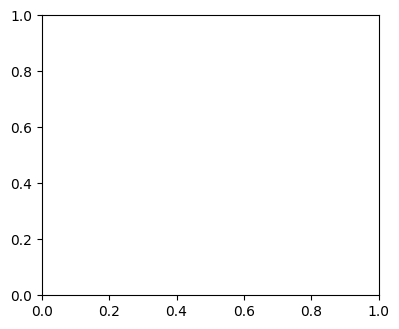

In [ ]:
plt.figure(figsize=(20,8))
for i, c in enumerate(["FAMI_ESTRATOVIVIENDA", 'ESTU_HORASSEMANATRABAJA', 'FAMI_TIENEINTERNET', 'ESTU_PAGOMATRICULAPROPIO']):
    plt.subplot(2, 4, i + 1)
    k = train[[c, "RENDIMIENTO_GLOBAL"]].dropna()

    for v in train[c].dropna().unique():
        sns.kdeplot(k.RENDIMIENTO_GLOBAL[k[c] == v], label=v)

    plt.title(c)
    plt.yticks([])

    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    plt.subplot(2, 4, i + 5)
    vc = k[c].value_counts()
    sns.barplot(y=vc.values, x=vc.index)
    plt.xticks(rotation="vertical")

plt.tight_layout()
plt.show()

In [ ]:

plt.figure(figsize=(20,8))
for i, c in enumerate(['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']):
    plt.subplot(2, 2, i + 1)
    k = train[[c, "RENDIMIENTO_GLOBAL"]].dropna()

    for v in train[c].dropna().unique():
        sns.kdeplot(k.RENDIMIENTO_GLOBAL[k[c] == v], label=v)

    plt.title(c)
    plt.yticks([])

    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    plt.subplot(2, 2, i + 3)
    vc = k[c].value_counts()
    sns.barplot(y=vc.values, x=vc.index)

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
for i, c in enumerate(['ESTU_VALORMATRICULAUNIVERSIDAD']):
    plt.figure(figsize=(20,13))
    plt.subplot(2, 1, 1)
    k = train[[c, "RENDIMIENTO_GLOBAL"]].dropna()

    for v in train[c].dropna().unique():
        sns.kdeplot(k.RENDIMIENTO_GLOBAL[k[c] == v], label=v)

    plt.title(c)
    plt.yticks([])

    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    plt.figure(figsize=(20,15))
    plt.subplot(2, 1, 2)
    vc = k[c].value_counts()
    sns.barplot(y=vc.values, x=vc.index)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20,8))

for i, c in enumerate(['ESTU_PRGM_DEPARTAMENTO']):
    plt.figure(figsize=(20,13))
    plt.subplot(2, 1, 1)
    k = train[[c, "RENDIMIENTO_GLOBAL"]].dropna()

    for v in train[c].dropna().unique():
        sns.kdeplot(k.RENDIMIENTO_GLOBAL[k[c] == v], label=v)

    plt.title(c)
    plt.yticks([])

    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

    plt.figure(figsize=(20,15))
    plt.subplot(2, 1, 2)
    vc = k[c].value_counts()
    sns.barplot(y=vc.values, x=vc.index)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## visualización de los datos faltantes

# Preprocesado

In [ ]:
def normalize_string(s):
    return (
        unicodedata.normalize('NFKD', s)
        .encode('ascii', errors='ignore')
        .decode('utf-8')
        .lower()
        .strip()
        .replace('  ', ' ')
    )

In [ ]:
def extraer_primera_palabra(texto):
    palabra = texto.replace('3','')
    palabra = palabra.split()[0]
    palabra= palabra.replace('-','')
    return palabra

In [43]:
mapeo_rendimiento = {
    'bajo': 1,
    'medio-bajo': 2,
    'medio-alto': 3,
    'alto': 4
  }
map_matricula ={
    'Entre 5.5 millones y menos de 7 millones': 6,
    'Entre 2.5 millones y menos de 4 millones': 4,
    'Entre 4 millones y menos de 5.5 millones': 5,
    'Más de 7 millones': 7,
    'Entre 1 millón y menos de 2.5 millones': 3,
    'Entre 500 mil y menos de 1 millón': 2,
    'Menos de 500 mil': 1

  }
mapeo_horas = {
    '0': 0,
    'Menos de 10 horas': 1,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 3,
    'Más de 30 horas': 4
  }
mapeo_estracto = {
    'Estrato 3':3,
    'Estrato 4':4,
    'Estrato 5':5,
    'Estrato 2':2,
    'Estrato 1':1,
    'Estrato 6':6,
    'Sin Estrato':0
  }

mapeo_region = {
     'BOGOTÁ': 'BOGOTÁ',
    'ATLANTICO': 'Caribe',
    'SANTANDER': 'Andina',
    'ANTIOQUIA': 'Andina',
    'HUILA': 'Andina',
    'SUCRE': 'Caribe',
    'CAQUETA': 'Amazonia',
    'CUNDINAMARCA': 'Andina',
    'BOLIVAR': 'Caribe',
    'TOLIMA': 'Andina',
    'VALLE': 'Andina',
    'QUINDIO': 'Andina',
    'RISARALDA': 'Andina',
    'CORDOBA': 'Caribe',
    'META': 'Orinoquia',
    'LA GUAJIRA': 'Caribe',
    'BOYACA': 'Andina',
    'NARIÑO': 'Andina',
    'CAUCA': 'Andina',
    'NORTE SANTANDER': 'Andina',
    'CESAR': 'Caribe',
    'PUTUMAYO': 'Amazonia',
    'CALDAS': 'Andina',
    'MAGDALENA': 'Caribe',
    'CHOCO': 'Pacífico',
    'CASANARE': 'Orinoquia',
    'ARAUCA': 'Orinoquia',
    'GUAVIARE': 'Orinoquia',
    'AMAZONAS': 'Amazonia',
    'VAUPES': 'Amazonia',
    'SAN ANDRES': 'Insular',
    'VICHADA': 'Orinoquia'
  }
def preprocess(dataframe):
  train = dataframe.copy()
  print("el shape inicial fue :")
  print(train.shape)
  target = 'RENDIMIENTO_GLOBAL'
  if(target in train):
    #train[target] = train[target].map(rmap)
    train[target] = train[target].map(mapeo_rendimiento)

  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(normalize_string)
  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(extraer_primera_palabra)

  frecuencia = train['ESTU_PRGM_ACADEMICO'].value_counts()
  top_10 = frecuencia.nlargest(10).index
  train['ESTU_PRGM_ACADEMICO'] = train['ESTU_PRGM_ACADEMICO'].apply(lambda x: x if x in top_10 else 'otra')

  train['ESTU_PRGM_DEPARTAMENTO'] = train['ESTU_PRGM_DEPARTAMENTO'].map(mapeo_region)
  train['FAMI_ESTRATOVIVIENDA'] = train['FAMI_ESTRATOVIVIENDA'].map(mapeo_estracto)
  train['ESTU_HORASSEMANATRABAJA'] = train['ESTU_HORASSEMANATRABAJA'].map(mapeo_horas)
  train["ESTU_VALORMATRICULAUNIVERSIDAD"] = train["ESTU_VALORMATRICULAUNIVERSIDAD"].map(map_matricula)

  modaPadre = train['FAMI_EDUCACIONMADRE'].mode()[0]
  modaMadre = train['FAMI_EDUCACIONPADRE'].mode()[0]
  train['FAMI_EDUCACIONMADRE'].fillna(modaMadre, inplace=True)
  train['FAMI_EDUCACIONPADRE'].fillna(modaPadre, inplace=True)
  one_hot_encoded_p = pd.get_dummies(train['FAMI_EDUCACIONPADRE'], prefix='FAMI_EDUCACIONPADRE')
  train = pd.concat([train, one_hot_encoded_p], axis=1)
  train.drop('FAMI_EDUCACIONPADRE', axis=1, inplace=True)
  one_hot_encoded_m = pd.get_dummies(train['FAMI_EDUCACIONMADRE'], prefix='FAMI_EDUCACIONMADRE')
  train = pd.concat([train, one_hot_encoded_m], axis=1)
  train.drop('FAMI_EDUCACIONMADRE', axis=1, inplace=True)
  #imputar a fami tiene internet
  modaInternet = train['FAMI_TIENEINTERNET'].mode()[0]
  train['FAMI_TIENEINTERNET'].fillna(modaInternet, inplace=True)
  #one hot a fami tiene internet
  one_hot_encoded_p = pd.get_dummies(train['FAMI_TIENEINTERNET'], prefix='FAMI_TIENEINTERNET')
  train = pd.concat([train, one_hot_encoded_p], axis=1)
  train.drop('FAMI_TIENEINTERNET', axis=1, inplace=True)

  chunk_size = 3000
  numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()
  num_rows = train.shape[0]
  imputer = KNNImputer(n_neighbors=3)
  for start in range(0, num_rows, chunk_size):
    end = min(start + chunk_size, num_rows)
    train.iloc[start:end, train.columns.get_indexer(numerical_cols)] = imputer.fit_transform(
        train.iloc[start:end, train.columns.get_indexer(numerical_cols)].to_numpy())
  #revisar como agrupar nombres de carreras
  label_encoder = LabelEncoder()
  categorical_columns = train.select_dtypes(include=['object']).columns
  for col in categorical_columns:
    train[col] = label_encoder.fit_transform(train[col])


  print("el shape final fue :" )
  print(train.shape)
  return train

In [40]:
trainPreprocesado = preprocess(trainKaggle)
testPreprocesado = preprocess(testKaggle)

el shape inicial fue :
(692500, 12)


<ipython-input-39-35c9f6124960>:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['FAMI_EDUCACIONMADRE'].fillna(modaMadre, inplace=True)
<ipython-input-39-35c9f6124960>:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

el shape final fue :
(692500, 35)
el shape inicial fue :
(296786, 12)


<ipython-input-39-35c9f6124960>:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['FAMI_EDUCACIONPADRE'].fillna(modaPadre, inplace=True)


el shape final fue :
(296786, 35)


<ipython-input-39-35c9f6124960>:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['FAMI_TIENEINTERNET'].fillna(modaInternet, inplace=True)


# Modelo

In [41]:
X = trainPreprocesado.drop(columns=["RENDIMIENTO_GLOBAL"])
y = trainPreprocesado["RENDIMIENTO_GLOBAL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [42]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200, max_depth=15)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200)

In [37]:
accuracy = model.score(X_test, y_test)
porcentaje_acierto = accuracy * 100
print(f"Porcentaje de acierto del modelo: {porcentaje_acierto:.2f}%")

Porcentaje de acierto del modelo: 40.44%


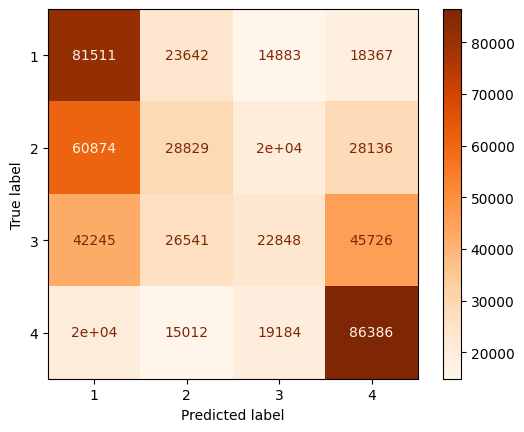

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Oranges)
plt.show()

# Envio a Kaggle

In [38]:
testPreprocesadoToSend = testPreprocesado.copy()
testPreprocesadoToSend.drop('Unnamed: 0', axis=1, inplace=True)
kagglePredictions = model.predict(testPreprocesadoToSend)
testPreprocesadoToSend['RENDIMIENTO_GLOBAL'] = kagglePredictions
envio = testPreprocesadoToSend[['ID','RENDIMIENTO_GLOBAL']]

mapeo_rendimiento = {
    1: 'bajo',
    2: 'medio-bajo',
    3: 'medio-alto',
    4: 'alto'
}
envio['RENDIMIENTO_GLOBAL'] = envio['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)
envio.to_csv('submission.csv', index=False)
!kaggle competitions submit -c udea-ai4eng-20242 -f submission.csv -m "agrupando por nombre de carrera, region del pais y max depth de 15"

<ipython-input-38-9b330107acd7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  envio['RENDIMIENTO_GLOBAL'] = envio['RENDIMIENTO_GLOBAL'].map(mapeo_rendimiento)


100% 3.95M/3.95M [00:00<00:00, 18.2MB/s]
Successfully submitted to UDEA/ai4eng 20242 - Pruebas Saber Pro Colombia